#### Step 3: Exploratory Data Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Read in the post dataset

In [2]:
data = pd.read_csv('../data/cleaned_posts.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4607 entries, 0 to 4606
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  4607 non-null   object
 1   title      4607 non-null   object
dtypes: object(2)
memory usage: 72.1+ KB


No null values for titles. In general, I got very lucky that the data I collected required little to no cleaning before being ready to use. 

Here I'm calculating the length of the titles in characters and in words. 

In [4]:
data['length'] = data['title'].str.len()

In [5]:
data['word_count'] = data['title'].str.count(' ') + 1

In [6]:
data.describe()

,length,word_count
count,4607.000000,4607.000000
mean,55.485783,9.944649
std,43.828537,8.318075
min,1.000000,1.000000
25%,28.000000,5.000000
50%,43.000000,7.000000
75%,68.000000,12.000000
max,300.000000,60.000000


Both counts seem promising. I think that the majority of titles being between 5 and 12 words is good, as there will be enough words to lock onto while still being mostly short enough that the majority of the words should be informative rather than noise. 

First I'm going to look at the distribution of word and character counts in titles across the two subreddits.

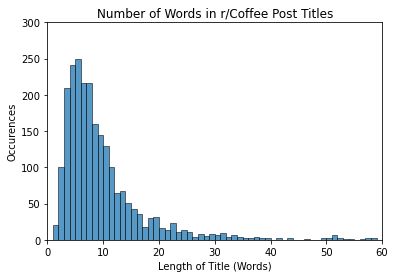

In [7]:
sns.histplot(data[data['subreddit'] == 'Coffee']['word_count'], binwidth=1)
plt.xlim(0, 60)
plt.ylim(0, 300)
plt.xlabel('Length of Title (Words)')
plt.ylabel('Occurences')
plt.title('Number of Words in r/Coffee Post Titles')
plt.show();

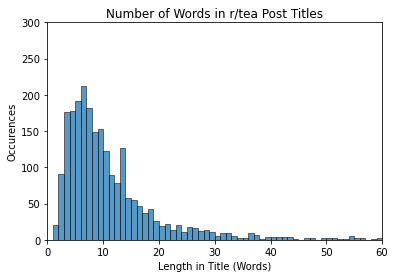

In [8]:
sns.histplot(data[data['subreddit'] == 'tea']['word_count'], binwidth=1)
plt.xlim(0, 60)
plt.ylim(0, 300)
plt.xlabel('Length in Title (Words)')
plt.ylabel('Occurences')
plt.title('Number of Words in r/tea Post Titles')
plt.show();

The word count distributions in r/tea and r/Coffee appear very similar, both approximately log-normal. The count in r/tea may have slightly higher variance. 

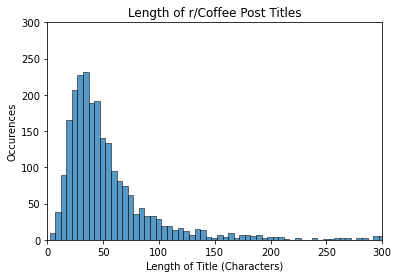

In [9]:
sns.histplot(data[data['subreddit'] == 'Coffee']['length'], binwidth=5)
plt.xlim(0, 300)
plt.ylim(0, 300)
plt.xlabel('Length of Title (Characters)')
plt.ylabel('Occurences')
plt.title('Length of r/Coffee Post Titles')
plt.show();

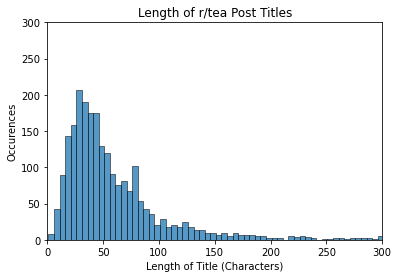

In [10]:
sns.histplot(data[data['subreddit'] == 'tea']['length'], binwidth=5)
plt.xlim(0, 300)
plt.ylim(0, 300)
plt.xlabel('Length of Title (Characters)')
plt.ylabel('Occurences')
plt.title('Length of r/tea Post Titles')
plt.show();

The distributions in character length seem even more similar than the word count distributions, and again both look approximately log-normal.

In building a classification model, the samples that most worry me are definitely the shortest ones, so I decided to take a look at some of the absolute shortest to see how big of an impact they might have.

In [11]:
data.sort_values(by='length').head(25)

,subreddit,title,length,word_count
760,tea,.,1,1
2627,Coffee,Si,2,1
3336,Coffee,No,2,1
4280,Coffee,👀☕,2,1
414,tea,Oh,2,1
612,tea,Tea,3,1
148,Coffee,New,3,1
4372,tea,🤣🤣🤣🤣,4,1
2573,Coffee,Mmmm,4,1
951,tea,Bulk,4,1


Obviously samples like these could be hard to blindly classify, but even at this level there are several that will likely train or test well, too--posts with titles of only a single word, but that word being something clearly identifiable like "oolong," or, obviously, "coffee" and "tea." 

To get a look at the words that are coming up in titles across the subreddits, I'll use a CountVectorizer to get simple counts without any stemming or lemmatization. 

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

I will use the stop words setting to exclude common words that don't provide any context.

In [13]:
cvect = CountVectorizer(stop_words='english')

In [14]:
X = data['title']

In [15]:
vect = cvect.fit_transform(X)

After transforming the data, I'll put it in a dataframe for easier viewing. 

In [16]:
df = pd.DataFrame(vect.toarray(), columns=cvect.get_feature_names())

I will then merge the vectorized array with the subreddit column to explore which words correlate with each subreddit. 

In [17]:
df_reddit = pd.merge(data['subreddit'], df, left_index=True, right_index=True)

By transposing the dataframe I can look at each word as an index value and sum across the whole sample, then add a column combining the counts across the two subreddits. 

In [18]:
counts = df_reddit.groupby(by='subreddit_x').sum().T
counts['total'] = counts['Coffee'] + counts['tea']

The top ten most common words on r/Coffee:

In [19]:
top_coffee_words = df_reddit.groupby(by='subreddit_x').sum().T.sort_values(
    by='Coffee', ascending=False)['Coffee']
top_coffee_words.head(10)

coffee      944
grinder     209
espresso    156
machine     117
help        111
new         109
beans        95
brew         94
best         87
good         87
Name: Coffee, dtype: int64

And the top ten most common words on r/tea:

In [20]:
top_tea_words = df_reddit.groupby(by='subreddit_x').sum().T.sort_values(
    by='tea', ascending=False)['tea']
top_tea_words.head(10)

tea          1412
new           151
cup           134
green         111
teas          105
christmas      98
got            92
matcha         87
like           83
teapot         83
Name: tea, dtype: int64

Unsurprising to see "coffee" and "tea" as the most common words in their respective subreddits. Any samples including those will likely be easy to classify. There does seem to be some amount of overlap in the other top words, though.

Here I can take a look at the top ten most common words across the two subreddits while comparing if they are more common in one or the other:

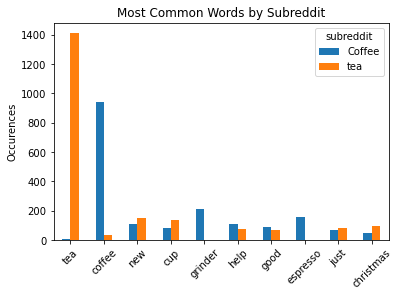

In [21]:
counts.sort_values(by='total', ascending=False).head(10).drop(
    columns='total').plot(kind='bar')
plt.title('Most Common Words by Subreddit')
plt.legend(title='subreddit')
plt.ylabel('Occurences')
plt.xticks(rotation=45)
plt.show()

It seems like "tea" and "coffee" still obviously dominate, and are much better represented in their home subreddits. This isn't novel information, so let's remove them to get a better look:

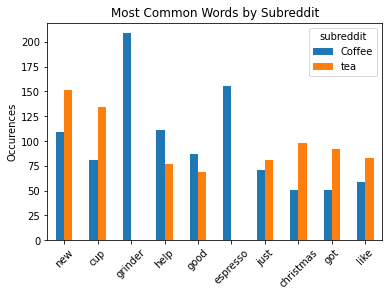

In [22]:
counts.sort_values(by='total', ascending=False).head(12).drop(
    columns='total').drop(labels=['coffee', 'tea']).plot(kind='bar')
plt.title('Most Common Words by Subreddit')
plt.legend(title='subreddit')
plt.ylabel('Occurences')
plt.xticks(rotation=45)
plt.show()

Here we start to see a lot more words with significant subreddit overlap, common terms like "new," "cup," and "like" will probably not be very useful features in classification. Additionally, with the time period that the posts were pulled from, it's unsurprising to see "christmas" among the top words. Thankfully there do seem to be a couple more easily recognizable words like "grinder," especially for r/Coffee. 